In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

from astroplan.plots import plot_airmass, plot_sky, plot_sky_24hr, plot_finder_image
from matplotlib import pyplot as plt
%matplotlib inline

from astroplan import Observer

from pocs.scheduler.dispatch import Scheduler
from pocs.scheduler.constraint import Duration, MoonAvoidance
from pocs.utils.config import load_config
from pocs.utils import listify

config = load_config()

In [3]:
# Get a location
loc = config['location']
location = EarthLocation(lon=loc['longitude'], lat=loc['latitude'], height=loc['elevation'])

# Get an observer at the location
observer = Observer(location=location)

# Get the night hours (you can use observer.tonight())
times = observer.tonight(horizon=-18 * u.degree)
start_of_night = times[0]
end_of_night = times[1]
# start_of_night = Time('2016-08-13 10:00:00')
# end_of_night = Time('2016-08-13 16:00:00')

In [4]:
simple_fields_file = config['directories']['targets'] + '/simple.yaml'

# Simple constraint to maximize duration above a certain altitude
constraints = [MoonAvoidance(), Duration(30 * u.deg)]

# Create a scheduler
scheduler = Scheduler(observer, fields_file=simple_fields_file, constraints=constraints)

In [5]:
for obs in scheduler.observations.values():
    print(obs)

Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100
M42: 120.0 s exposures in blocks of 5, minimum 10, priority 75
M5: 120.0 s exposures in blocks of 10, minimum 60, priority 50
Kepler 1100: 120.0 s exposures in blocks of 10, minimum 60, priority 125
Wasp 36: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 11: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 35: 120.0 s exposures in blocks of 10, minimum 60, priority 110
Qatar-1: 120.0 s exposures in blocks of 10, minimum 60, priority 100
M45: 120.0 s exposures in blocks of 10, minimum 60, priority 50
Wasp 2: 120.0 s exposures in blocks of 10, minimum 60, priority 110
HAT-P-20: 120.0 s exposures in blocks of 10, minimum 60, priority 100
EPIC-211089792: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 140: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HAT-P-1: 120.0 s exposures in blocks 

In [6]:
# Get the best observations for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(time=start_of_night, show_all=True)

for b in listify(best):
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

2016-11-22 13:53:57 ganymede panoptes[5671] INFO Setting new observation to HD 189733: 90.0 s exposures in blocks of 10, minimum 60, priority 105


Field: HD 189733    Merit: 106.8762007289609
Field: Wasp 33      Merit: 102.41182364542425
Field: HD 209458    Merit: 102.19101624395398


In [7]:
scheduler.current_observation.field.coord.equinox

'J2000'

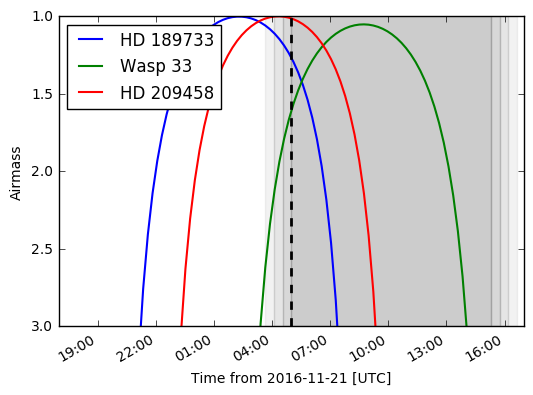

In [8]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, start_of_night, 
             brightness_shading=True)
        
plt.axvline(start_of_night.plot_date, lw=2, ls='--', c='k')    
plt.legend(loc=2)
plt.show()

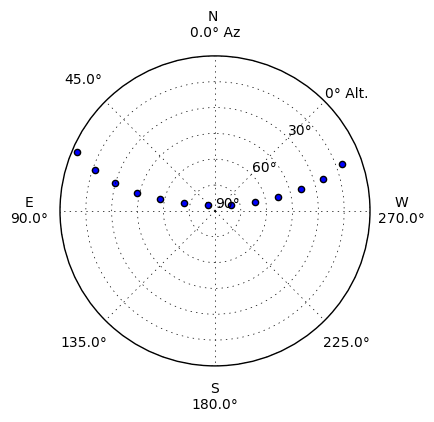

In [9]:
plot_sky_24hr(scheduler.current_observation.field, scheduler.observer, start_of_night)
plt.show()

In [10]:
# Set a later time to start
t2 = end_of_night - 3 * u.hour

# Get the best observation for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(show_all=True, time=t2)

for b in best:
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

2016-11-22 13:54:18 ganymede panoptes[5671] INFO Setting new observation to Wasp 35: 120.0 s exposures in blocks of 10, minimum 60, priority 110


Field: Wasp 35      Merit: 112.40144430295452
Field: EPIC-211089792 Merit: 102.37483944879848
Field: Wasp 36      Merit: 102.20738151619373
Field: M42          Merit: 77.46075403365155
Field: M45          Merit: 52.273760582836076
Field: M44          Merit: 52.20725229831013


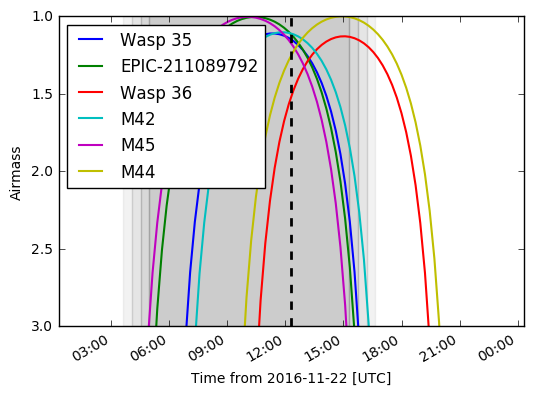

In [11]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, t2, 
             brightness_shading=True)
plt.axvline(t2.plot_date, lw=2, ls='--', c='k')
plt.legend(loc=2)
plt.show()

## Entire Night Simulation

Now let's simulate going through the whole evening

In [12]:
# Start at the beginning of the night
next_time = start_of_night
print("Start of night at {}".format(start_of_night))

# Reset scheduler
# Create a scheduler
scheduler = Scheduler(observer, fields_file=simple_fields_file, constraints=constraints)

while (next_time < end_of_night):    
    # Only get new target if we have met min_nexp for observation
    if (scheduler.current_observation is None) or \
        (scheduler.current_observation.current_exp >= scheduler.current_observation.min_nexp):
            
        # delete the observation that was just observed
        scheduler.observation.remove(schelduler.current_observation)
        
        # if there is no more observations to be made shut down pocs
        if len(scheduler.observations) = 0:
            print("No more observations\nPOCS shutting down")
            <shut down pocs>
        
        print("Getting new observation at {}".format(next_time))
        new_obs = scheduler.get_observation(time=next_time)
        
    if scheduler.current_observation is not None:

        if (scheduler.current_observation.current_exp < scheduler.current_observation.min_nexp):
            obs_duration = scheduler.current_observation.minimum_duration

            # Fake the exposure count
            scheduler.current_observation.current_exp = scheduler.current_observation.min_nexp
        else:
            obs_duration = scheduler.current_observation.set_duration
            # Fake the exposure count
            scheduler.current_observation.current_exp += scheduler.current_observation.exp_set_size

        print("\tWill observe {} with merit of {:0.5f} for {}".format(
                    scheduler.current_observation.name, 
                    scheduler.current_observation.merit, 
                    obs_duration))
        print("\t{} of {}".format(scheduler.current_observation.current_exp, 
                                  scheduler.current_observation.min_nexp))
                
    next_time = next_time + obs_duration
    
print("End of night at {}".format(end_of_night.isot))

Start of night at 2457714.707653686
Getting new observation at 2457714.707653686


2016-11-22 13:54:39 ganymede panoptes[5671] INFO Setting new observation to HD 189733: 90.0 s exposures in blocks of 10, minimum 60, priority 105


	Will observe HD 189733 with merit of 106.87620 for 5400.0 s
	60 of 60
Getting new observation at 2457714.770153686


2016-11-22 13:54:55 ganymede panoptes[5671] INFO Setting new observation to EPIC-211089792: 120.0 s exposures in blocks of 10, minimum 60, priority 100


	Will observe EPIC-211089792 with merit of 102.47273 for 7200.0 s
	60 of 60
Getting new observation at 2457714.8534870194


2016-11-22 13:55:15 ganymede panoptes[5671] INFO Setting new observation to Wasp 35: 120.0 s exposures in blocks of 10, minimum 60, priority 110


	Will observe Wasp 35 with merit of 112.44761 for 7200.0 s
	60 of 60
Getting new observation at 2457714.9368203525


2016-11-22 13:55:27 ganymede panoptes[5671] INFO Setting new observation to EPIC-211089792: 120.0 s exposures in blocks of 10, minimum 60, priority 100


	Will observe EPIC-211089792 with merit of 102.43670 for 7200.0 s
	60 of 60
Getting new observation at 2457715.020153686


2016-11-22 13:55:42 ganymede panoptes[5671] INFO Setting new observation to Wasp 35: 120.0 s exposures in blocks of 10, minimum 60, priority 110


	Will observe Wasp 35 with merit of 112.39528 for 7200.0 s
	60 of 60
Getting new observation at 2457715.1034870194


2016-11-22 13:55:56 ganymede panoptes[5671] INFO Setting new observation to M42: 120.0 s exposures in blocks of 5, minimum 10, priority 75


	Will observe M42 with merit of 77.46516 for 1200.0 s
	10 of 10
Getting new observation at 2457715.117375908


2016-11-22 13:56:09 ganymede panoptes[5671] INFO Setting new observation to M42: 120.0 s exposures in blocks of 5, minimum 10, priority 75


	Will observe M42 with merit of 77.46573 for 600.0 s
	15 of 10
Getting new observation at 2457715.1243203525
	Will observe M42 with merit of 77.46573 for 600.0 s
	20 of 10
Getting new observation at 2457715.131264797


2016-11-22 13:56:40 ganymede panoptes[5671] WARNING No valid observations found
2016-11-22 13:56:40 ganymede panoptes[5671] INFO Setting new observation to None


End of night at 2016-11-22T15:18:09.529


In [13]:
time = Time('2016-08-13 11:00:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

time = Time('2016-08-13 13:00:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

time = Time('2016-08-13 14:30:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

2016-11-22 13:56:56 ganymede panoptes[5671] INFO Setting new observation to KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 130


KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 130
KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 130


2016-11-22 13:57:23 ganymede panoptes[5671] WARNING No valid observations found
2016-11-22 13:57:23 ganymede panoptes[5671] INFO Setting new observation to None


None


In [14]:
scheduler.current_observation 